# Modelling

In [60]:
import helpers
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score,  balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from skopt.space import Integer
from skopt.space import Categorical
from skopt.space import Real
import warnings
import json
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [61]:
df = pd.read_pickle("./df_merge_club_transfer_data.pkl")
df1 = pd.read_pickle("./df_merge_club_transfer_data_prep1.pkl")
object_columns = df.select_dtypes(include=['object']).columns
RANDOM_STATE = 42
TEST_SIZE_PERCENT = 0.2

## 2nd step of data preparation

In [66]:
df2 = df1.copy()

In [67]:
# Kombinieren die Werte beider Spalten in eine Serie
combined_teams = pd.concat([df2['HOME_TEAM'], df2['AWAY_TEAM']])

# Initialisieren und anpassen Sie den LabelEncoder
le_teams = LabelEncoder()
le_teams.fit(combined_teams)

# Codieren Sie die 'HOME_TEAM' und 'AWAY_TEAM' Spalten
df2['HOME_TEAM'] = le_teams.transform(df2['HOME_TEAM'])
df2['AWAY_TEAM'] = le_teams.transform(df2['AWAY_TEAM'])

# Erstellen ein Mapping-Dictionary für die Decodierung
label_mapping_TEAM = {idx: label for idx, label in enumerate(le_teams.classes_)}

print("Label Mapping:", label_mapping_TEAM)

Label Mapping: {0: '1.FC Kaiserslautern', 1: '1.FC Köln', 2: '1.FC Nürnberg', 3: '1.FC Union Berlin', 4: '1.FSV Mainz 05', 5: 'Alemannia Aachen', 6: 'Arminia Bielefeld', 7: 'Bayer 04 Leverkusen', 8: 'Borussia Dortmund', 9: 'Borussia Mönchengladbach', 10: 'Eintracht Braunschweig', 11: 'Eintracht Frankfurt', 12: 'FC Augsburg', 13: 'FC Bayern München', 14: 'FC Energie Cottbus', 15: 'FC Hansa Rostock', 16: 'FC Ingolstadt 04', 17: 'FC Schalke 04', 18: 'FC St. Pauli', 19: 'Fortuna Düsseldorf', 20: 'Hamburger SV', 21: 'Hannover 96', 22: 'Hertha BSC', 23: 'Karlsruher SC', 24: 'MSV Duisburg', 25: 'RasenBallsport Leipzig', 26: 'SC Freiburg', 27: 'SC Paderborn 07', 28: 'SV Darmstadt 98', 29: 'SV Werder Bremen', 30: 'SpVgg Greuther Fürth', 31: 'TSG 1899 Hoffenheim', 32: 'VfB Stuttgart', 33: 'VfL Bochum', 34: 'VfL Wolfsburg'}


In [68]:
le_REFEREE = LabelEncoder()
encoded_REFEREE = le_REFEREE.fit_transform(df2['REFEREE'])
df2['REFEREE'] = encoded_REFEREE

label_mapping_REFEREE = {idx: label for idx, label in enumerate(le_REFEREE.classes_)}
print("Label Mapping:", label_mapping_REFEREE)

Label Mapping: {0: 'Babak Rafati', 1: 'Bastian Dankert', 2: 'Benjamin Brand', 3: 'Benjamin Cortus', 4: 'Bibiana Steinhaus-Webb', 5: 'Christian Dingert', 6: 'Daniel Schlager', 7: 'Daniel Siebert', 8: 'Deniz Aytekin', 9: 'Dr. Arne Aarnink', 10: 'Dr. Felix Brych', 11: 'Dr. Franz-Xaver Wack', 12: 'Dr. Helmut Fleischer', 13: 'Dr. Jochen Drees', 14: 'Dr. Markus Merk', 15: 'Dr. Martin Thomsen', 16: 'Dr. Matthias Jöllenbeck', 17: 'Dr. Robert Kampka', 18: 'Dr. Robin Braun', 19: 'Felix Zwayer', 20: 'Florian Badstübner', 21: 'Florian Meyer', 22: 'Frank Willenborg', 23: 'Guido Winkmann', 24: 'Günter Perl', 25: 'Harm Osmers', 26: 'Herbert Fandel', 27: 'Hermann Albrecht', 28: 'Jörg Keßler', 29: 'Jürgen Jansen', 30: 'Knut Kircher', 31: 'Lutz Wagner', 32: 'Lutz-Michael Fröhlich', 33: 'Manuel Gräfe', 34: 'Marc Seemann', 35: 'Marco Fritz', 36: 'Markus Schmidt', 37: 'Markus Wingenbach', 38: 'Martin Petersen', 39: 'Michael Kempter', 40: 'Michael Weiner', 41: 'Patrick Ittrich', 42: 'Peter Gagelmann', 43: '

In [69]:
le_RESULT = LabelEncoder()
encoded_RESULT = le_RESULT.fit_transform(df2['RESULT'])
df2['RESULT'] = encoded_RESULT

label_mapping_RESULT = {idx: label for idx, label in enumerate(le_RESULT.classes_)}
print("Label Mapping:", label_mapping_RESULT)

Label Mapping: {0: 'AWAY_WIN', 1: 'DRAW', 2: 'HOME_WIN'}


In [8]:
print(df2.dtypes)

DATE                            datetime64[ns]
WEEKDAY                                  int64
MONTH                                    int64
SEASON                                   int32
MATCHDAY                                 int64
HOME_TEAM                                int32
PLACE_HOME_TEAM                          int64
AWAY_TEAM                                int32
PLACE_AWAY_TEAM                          int64
WIN_PERC_HOME                          float64
REMIS_PERC                             float64
WIN_PERC_AWAY                          float64
HOME_GOALS                             float64
AWAY_GOALS                             float64
RESULT                                   int32
REFEREE                                  int32
HOME_PLAYERS_COUNT                       int64
HOME_PLAYERS_AVG_AGE                   float64
HOME_LEGIONARIES_COUNT                   int64
HOME_AVG_MARKET_VALUE                  float64
HOME_TOTAL_MARKET_VALUE                float64
HOME_AVG_AGE_

In [9]:
print(df2[object_columns].iloc[0])

HOME_TEAM                             29.00
PLACE_HOME_TEAM                        3.00
AWAY_TEAM                             17.00
PLACE_AWAY_TEAM                        2.00
RESULT                                 2.00
REFEREE                               47.00
HOME_PLAYERS_COUNT                    29.00
HOME_PLAYERS_AVG_AGE                  25.00
HOME_LEGIONARIES_COUNT                14.00
HOME_AVG_MARKET_VALUE            3400000.00
HOME_TOTAL_MARKET_VALUE         98480000.00
HOME_AVG_AGE_LEAVING                  26.40
HOME_TOTAL_VALUE_JOINING_MIO            NaN
HOME_TOTAL_VALUE_LEAVING_MIO            NaN
HOME_EXPENSES_JOINING_MIO              9.00
HOME_REVENUE_LEAVING_MIO               6.45
AWAY_PLAYERS_COUNT                    33.00
AWAY_PLAYERS_AVG_AGE                  25.60
AWAY_LEGIONARIES_COUNT                15.00
AWAY_AVG_MARKET_VALUE            2620000.00
AWAY_TOTAL_MARKET_VALUE         86330000.00
AWAY_AVG_AGE_LEAVING                  27.80
AWAY_TOTAL_VALUE_JOINING_MIO    

In [10]:
nan_count = df2.isna().sum()
print(nan_count)
print(len(df))

DATE                               0
WEEKDAY                            0
MONTH                              0
SEASON                             0
MATCHDAY                           0
HOME_TEAM                          0
PLACE_HOME_TEAM                    0
AWAY_TEAM                          0
PLACE_AWAY_TEAM                    0
WIN_PERC_HOME                   1530
REMIS_PERC                      1530
WIN_PERC_AWAY                   1530
HOME_GOALS                         0
AWAY_GOALS                         0
RESULT                             0
REFEREE                            0
HOME_PLAYERS_COUNT                 0
HOME_PLAYERS_AVG_AGE               0
HOME_LEGIONARIES_COUNT             0
HOME_AVG_MARKET_VALUE              0
HOME_TOTAL_MARKET_VALUE            0
HOME_AVG_AGE_JOINING               0
HOME_AVG_AGE_LEAVING               0
HOME_TOTAL_VALUE_JOINING_MIO     748
HOME_TOTAL_VALUE_LEAVING_MIO    1224
HOME_EXPENSES_JOINING_MIO         85
HOME_REVENUE_LEAVING_MIO         272
A

In [11]:
df2.to_pickle("df_merge_club_transfer_data_prep2.pkl")

## Modelling

In [70]:
selected_features = [
"HOME_TEAM", "PLACE_HOME_TEAM", "HOME_PLAYERS_COUNT", "HOME_PLAYERS_AVG_AGE", "HOME_LEGIONARIES_COUNT",
"HOME_AVG_MARKET_VALUE", "HOME_TOTAL_MARKET_VALUE", "HOME_AVG_AGE_JOINING", "HOME_AVG_AGE_LEAVING", 
#"HOME_TOTAL_VALUE_JOINING_MIO","HOME_TOTAL_VALUE_LEAVING_MIO",
"AWAY_TEAM", "PLACE_AWAY_TEAM", "AWAY_PLAYERS_COUNT", "AWAY_PLAYERS_AVG_AGE", "AWAY_LEGIONARIES_COUNT",
"AWAY_AVG_MARKET_VALUE", "AWAY_TOTAL_MARKET_VALUE", "AWAY_AVG_AGE_JOINING", "AWAY_AVG_AGE_LEAVING", 
#"AWAY_TOTAL_VALUE_JOINING_MIO", "AWAY_TOTAL_VALUE_LEAVING_MIO",
"MATCHDAY"
]

In [71]:
X = df2[selected_features]
y = df2['RESULT']
# Daten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PERCENT, shuffle=False)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [72]:
X_test

,HOME_TEAM,PLACE_HOME_TEAM,HOME_PLAYERS_COUNT,HOME_PLAYERS_AVG_AGE,HOME_LEGIONARIES_COUNT,HOME_AVG_MARKET_VALUE,HOME_TOTAL_MARKET_VALUE,HOME_AVG_AGE_JOINING,HOME_AVG_AGE_LEAVING,AWAY_TEAM,PLACE_AWAY_TEAM,AWAY_PLAYERS_COUNT,AWAY_PLAYERS_AVG_AGE,AWAY_LEGIONARIES_COUNT,AWAY_AVG_MARKET_VALUE,AWAY_TOTAL_MARKET_VALUE,AWAY_AVG_AGE_JOINING,AWAY_AVG_AGE_LEAVING,MATCHDAY
0,34,7,38,24.7,23,5460000.0,207600000.0,22.8,24.0,3,15,34,26.2,11,1210000.0,41200000.0,23.5,24.0,7
1,11,9,35,26.4,23,5970000.0,208980000.0,24.4,23.5,29,11,36,26.2,18,3750000.0,135130000.0,23.3,23.5,7
2,11,9,35,26.4,23,5970000.0,208980000.0,24.4,23.5,7,7,29,25.1,18,13760000.0,398950000.0,21.4,23.5,8
3,25,4,38,23.0,26,15010000.0,570480000.0,20.7,22.5,34,2,38,24.7,23,5460000.0,207600000.0,22.8,24.0,8
4,29,11,36,26.2,18,3750000.0,135130000.0,23.3,23.5,22,10,42,24.2,22,5170000.0,217200000.0,22.1,22.5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1158,9,11,35,25.4,16,6910000.0,241680000.0,22.1,23.8,12,14,42,25.0,23,3150000.0,132280000.0,22.6,24.6,34
1159,11,8,36,25.0,22,9020000.0,324550000.0,22.6,24.2,26,5,29,26.0,11,6930000.0,200950000.0,23.3,23.1,34
1160,34,7,33,24.7,20,7220000.0,238300000.0,22.3,24.6,22,18,41,25.4,21,2290000.0,94000000.0,23.7,24.4,34
1161,33,16,32,27.7,18,1680000.0,53700000.0,25.4,26.0,7,6,35,24.2,24,12930000.0,452550000.0,21.8,24.6,34


In [36]:
total_rows = len(df2)

# Zähle die Anzahl jeder eindeutigen Werte in der Spalte "result"
value_counts = df2['RESULT'].value_counts()

# Berechne die prozentuale Verteilung
percentage_distribution = (value_counts / total_rows) * 100

print("Prozentuale Verteilung der Werte in der Spalte 'RESULT':")
print(percentage_distribution)

Prozentuale Verteilung der Werte in der Spalte 'RESULT':
2    45.252838
0    29.944960
1    24.802202
Name: RESULT, dtype: float64


In [37]:
total_samples = total_rows  # Gewichtung der Klassen
weights_for_classes = {
    0: total_samples / (3 * 29.944960),  # 3 Klassen, daher durch 3 teilen
    1: total_samples / (3 * 24.802202),
    2: total_samples / (3 * 45.252838)
}

## RandomForestClassifier

In [73]:
warnings.filterwarnings("ignore", category=UserWarning, message=".*Precision and F-score are ill-defined.*") 
search_space = {
    'n_estimators': Integer(10, 300),          # Ganzzahlige Variable
    'max_depth': Integer(3, 10),               # Ganzzahlige Variable
    'criterion': Categorical(['gini', 'entropy']),  # Kategorische Variable
    'class_weight': Categorical([None, 'balanced']),  # Keine Klassengewichtung, Automatische Klassengweichtung
    'max_features': Real(0.1, 0.999, prior='uniform')  # Reelle Variable
    # 'min_samples_split': Integer(2, 20),
    # 'min_samples_leaf': Integer(1, 20),
}

# Bayes'sche Optimierung
opt_rmforest = BayesSearchCV(
    RandomForestClassifier(),
    search_space,
    cv=5,  # 5-fache Kreuzvalidierung
    n_iter=50,  # Anzahl der Iterationen
    n_jobs=-1  # Parallelisierung (-1: alle Kerne verwenden)
)

# Optimierung auf dem Trainings- und Validierungsdatensatz
opt_rmforest.fit(X_train, y_train)

# Beste Parameter ausgeben
print("Best parameters found:", opt_rmforest.best_params_)

Best parameters found: OrderedDict([('class_weight', None), ('criterion', 'gini'), ('max_depth', 6), ('max_features', 0.42156565750356567), ('n_estimators', 300)])


In [74]:
model_name = 'random_forest'
result = helpers.get_model_forecast_results(opt_rmforest, X_test, y_test, le_teams, is_optimizer=True)
with open(f'./results/{model_name}_results.json', 'w') as f:
  json.dump(result, f) 

Accuracy: 0.5090283748925194
Balanced Accuracy: 0.43419583751075463

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.53      0.50       362
           1       0.00      0.00      0.00       283
           2       0.53      0.77      0.63       518

    accuracy                           0.51      1163
   macro avg       0.33      0.43      0.38      1163
weighted avg       0.38      0.51      0.44      1163



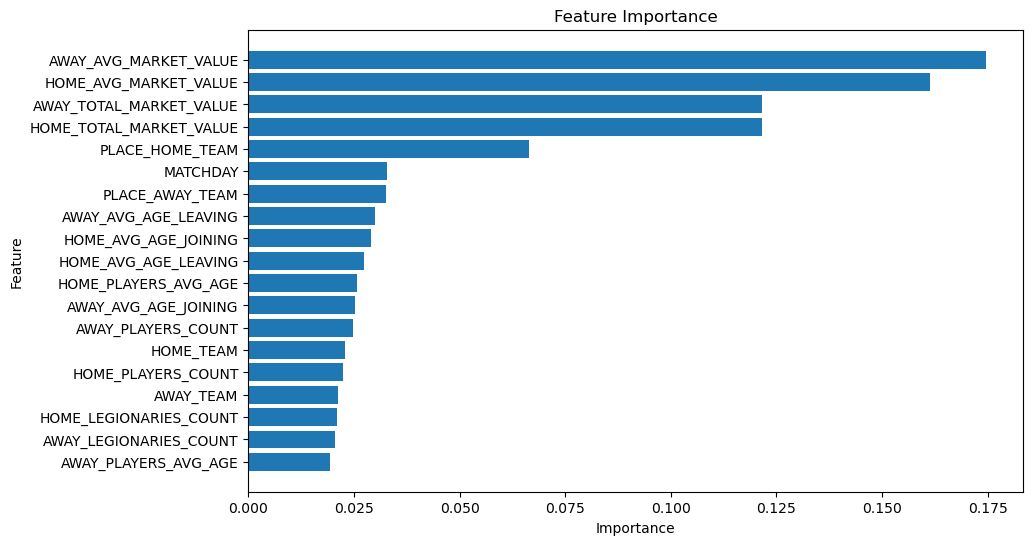

In [75]:
best_model = opt_rmforest.best_estimator_

# Feature-Importance auslesen
feature_importance = best_model.feature_importances_

feature_names = X.columns.tolist()  # Ersetzen Sie dies durch die echten Feature-Namen
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

feature_importance_df.sort_values(by='Importance', ascending=True, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

## KNeighborsClassifier

In [17]:
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings("ignore", message="The objective has been evaluated at this point before.")
search_space = {
  'n_neighbors': Integer(1, 30),
    'weights': Categorical(['uniform', 'distance']),
    'metric': Categorical(['euclidean', 'manhattan', 'minkowski']),
    'p': Integer(1, 6),
    'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute'])
}

# Bayes'sche Optimierung
opt_knn = BayesSearchCV(
    KNeighborsClassifier(),
    search_space,
    cv=5,  # 5-fache Kreuzvalidierung
    n_iter=40,  # Anzahl der Iterationen
    n_jobs=-1  # Parallelisierung (-1: alle Kerne verwenden)
)

# Optimierung auf dem Trainings- und Validierungsdatensatz
opt_knn.fit(X_train, y_train)

# Beste Parameter ausgeben
print("Best parameters found:", opt_knn.best_params_)

Best parameters found: OrderedDict([('algorithm', 'auto'), ('metric', 'minkowski'), ('n_neighbors', 30), ('p', 6), ('weights', 'uniform')])


In [18]:
model_name = 'kneighbors'
result = helpers.get_model_forecast_results(opt_knn, X_test, y_test, le_teams, is_optimizer=True)
with open(f'./results/{model_name}_results.json', 'w') as f:
  json.dump(result, f) 

Accuracy: 0.5081685296646603
Balanced Accuracy: 0.43834127410841

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.52      0.50       362
           1       0.29      0.04      0.06       283
           2       0.54      0.75      0.63       518

    accuracy                           0.51      1163
   macro avg       0.44      0.44      0.40      1163
weighted avg       0.46      0.51      0.45      1163



## MultinomialNB

In [19]:
from sklearn.naive_bayes import MultinomialNB
warnings.filterwarnings("ignore", message="`np.int` is a deprecated alias for the builtin `int`")
search_space = {
    'alpha': Real(0, 1, prior='uniform'),  # oder auch Integer, wenn Sie diskrete Werte möchten
    'fit_prior': Categorical([True, False])
}

# Bayes'sche Optimierung
opt_mnb = BayesSearchCV(
    MultinomialNB(),
    search_space,
    cv=5,  # 5-fache Kreuzvalidierung
    n_iter=40,  # Anzahl der Iterationen
    n_jobs=-1  # Parallelisierung (-1: alle Kerne verwenden)
)

# Optimierung auf dem Trainings- und Validierungsdatensatz
opt_mnb.fit(X_train, y_train)

# Beste Parameter ausgeben
print("Best parameters found:", opt_mnb.best_params_)

Best parameters found: OrderedDict([('alpha', 0.23334165941032675), ('fit_prior', False)])


In [20]:
model_name = 'multinominalNB'
result = helpers.get_model_forecast_results(opt_mnb, X_test, y_test, le_teams, is_optimizer=True)
with open(f'./results/{model_name}_results.json', 'w') as f:
  json.dump(result, f) 

Accuracy: 0.4858125537403267
Balanced Accuracy: 0.4461159447884162

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.58      0.50       362
           1       0.27      0.16      0.20       283
           2       0.59      0.60      0.59       518

    accuracy                           0.49      1163
   macro avg       0.44      0.45      0.43      1163
weighted avg       0.47      0.49      0.47      1163



## GaussianNB

In [21]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [22]:
model_name = 'gaussian_naive_bayes'
result = helpers.get_model_forecast_results(gnb, X_test, y_test, le_teams, is_optimizer=False)
with open(f'./results/{model_name}_results.json', 'w') as f:
  json.dump(result, f) 

Accuracy: 0.5064488392089423
Balanced Accuracy: 0.43660097188785474

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.55      0.50       362
           1       0.24      0.02      0.03       283
           2       0.54      0.75      0.63       518

    accuracy                           0.51      1163
   macro avg       0.41      0.44      0.39      1163
weighted avg       0.44      0.51      0.44      1163



## QuadraticDiscriminantAnalysis

In [23]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
warnings.filterwarnings("ignore", message="`np.int` is a deprecated alias for the builtin `int`")
search_space = {
    'tol': Real(1e-4,  1e-2, prior='uniform'),  # Annahme von 2 Klassen
    'reg_param': Real(0, 1, prior='uniform'),
    'store_covariance': Categorical([True, False])
}
# Bayes'sche Optimierung
opt_qda = BayesSearchCV(
    QuadraticDiscriminantAnalysis(),
    search_space,
    cv=5,  # 5-fache Kreuzvalidierung
    n_iter=40,  # Anzahl der Iterationen
    n_jobs=-1  # Parallelisierung (-1: alle Kerne verwenden)
)

# Optimierung auf dem Trainings- und Validierungsdatensatz
opt_qda.fit(X_train, y_train)

# Beste Parameter ausgeben
print("Best parameters found:", opt_qda.best_params_)

Best parameters found: OrderedDict([('reg_param', 0.031043668392755665), ('store_covariance', True), ('tol', 0.00020004089942541345)])


In [24]:
model_name = 'quadratic_discriminant_analysis'
result = helpers.get_model_forecast_results(opt_qda, X_test, y_test, le_teams, is_optimizer=False)
with open(f'./results/{model_name}_results.json', 'w') as f:
  json.dump(result, f) 

Accuracy: 0.5030094582975064
Balanced Accuracy: 0.4453497565380899

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.57      0.51       362
           1       0.25      0.07      0.11       283
           2       0.57      0.69      0.63       518

    accuracy                           0.50      1163
   macro avg       0.43      0.45      0.42      1163
weighted avg       0.46      0.50      0.46      1163

